# SNIS IPLA

In [80]:
import numpy as np
from tqdm import tqdm
from implementation import IPLA, SNIS_IPLA, PGD, SVGD_EM
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn import datasets
import pandas as pd
plt.rcParams['figure.dpi'] = 200

In [81]:
file_path = "breast-cancer-wisconsin.data"

full_data = pd.read_csv(file_path, delimiter=",", header=None, index_col=0)
# replace non numeric values with NaN
full_data = full_data.where(full_data.applymap(
    lambda x: str(x).isdigit()
))

full_data.dropna(inplace=True)
full_data = full_data.astype(int)
train_data = full_data.sample(frac=0.8, random_state=0)
test_data = full_data.drop(train_data.index)
print(full_data.shape)
test_labels = test_data[10].to_numpy()
train_labels = train_data[10].to_numpy()
test_data = test_data.drop(10, axis=1).to_numpy()
train_data = train_data.drop(10, axis=1).to_numpy()
y_train = [train_data, train_labels]
y_test = [test_data, test_labels]


(683, 10)


## Auxiliary functions

We will test with:

$$
p(\theta,x, y) = \prod_{d=1}^D\exp\left(-\frac{(x_d-\theta)^2}{2} - \frac{(y_d-x_d)^2}{2}-\log(2\pi)\right)
$$

$$
= \exp\left(-D\log(2\pi)-\left[\sum_{d=1}^D\frac{(x_d-\theta)^2}{2} + \frac{(y_d-x_d)^2}{2}\right]\right)
$$

$$
\nabla_\theta p(\theta,x,y) = p(\theta, x, y)\left\{\sum_{d=1}^D x_d - D\theta\right\}
$$

In [82]:
def p(theta, x, y):
    D = np.shape(x)[0]
    return np.exp(-np.sum((x-theta)**2/2) - np.sum((y-x)**2/2) - D*np.log(2*np.pi))

def p_grad_theta(theta, x, y):
    D = np.shape(x)[0]
    return -(np.sum(x) - D*theta) * p(theta, x, y)

def log_p_grad_theta(theta, x, y):
    D = x.shape[0]
    return (np.sum(x) - D*theta)*p(theta, x, y)

def U(theta, Xi, y):
    D = np.shape(Xi)[0]
    return D * np.log(2*np.pi) + np.sum((Xi-theta)**2/2) + np.sum((y-Xi)**2/2)

def U_grad_X(theta, x, y):
    return -(-2*x + y + theta)

def U_grad_theta(theta, Xi, y):
    D = np.shape(Xi)[0]
    return D*(theta - np.mean(Xi))

def ave_grad_U_theta(theta, X, y):
    D, N = np.shape(X)
    return D*(theta - np.mean(X))

def exponential_kernel(x1, x2, sigma=1):
    return np.exp(-np.sum((x1-x2)**2)/(2*sigma**2))

def grad_exponential_kernel_x1(x1, x2, sigma=1):
    return ((x2-x1)/(sigma**2)) * np.exp(-np.sum((x1-x2)**2/(2*sigma**2)))

We also implement Bayesian logistic regression, where $p$ is of the form:

$$
p_\theta(x, y) = \mathcal{N}(x;\theta 1_{D_x}, 5I_{D_x})\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}
\\= \frac{1}{(2\pi)^{D_x/2}5^{D_x/2}}\exp\left(-\frac{\|x-1_{D_x}\theta\|^2}{10}\right)\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}
$$

And:

$$
\nabla_\theta p_\theta(x,y)= \frac{1}{(2\pi)^{D_x/2}5^{D_x/2}}\exp\left(-\frac{\|x-1_{D_x}\theta\|^2}{10}\right)\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}\left(\frac{2}{5}(1_{D_x}\theta - x)\right)
$$

Observe that then, $U$ becomes:

$$
U(\theta, x) = \sum_{(f,\,l)\in y} [\log(1+e^{f^\top x}) - lf^\top x]+ \frac{\|x-1_{D_x}\theta\|^2}{5}
$$

Then:

$$
\nabla_x U(\theta,x) = \sum_{(f,l)\in y}\left[-lf + \frac{fe^{x^\top f}}{1+e^{f^\top x}}\right] + \frac{2}{5}(x-1_{D_x}\theta)
$$

$$
\nabla_\theta U(\theta,x) = \frac{2}{5}(1_{D_x}\theta - x)
$$

And so:

$$
\frac{1}{N}\sum_{i=1}^N\nabla_\theta U(\theta,x_i) = \frac{2}{5N}\sum_{i=1}^N(1_{D_x}\theta - x_i) = \frac{2}{5}(1_{D_x}\theta - \bar{x})
$$

In [146]:
def ave_grad_U_theta_regression(theta, X, y):
    Dx = np.shape(X)[0]
    return (2/5)*(np.ones(Dx)*theta - np.mean(X, axis=1))

def grad_U_Xi_regression(theta, Xi, y):
    Dx = np.shape(Xi)[0]
    f = y[0]
    l = y[1].reshape(-1,1)
    return  np.sum(-l*f + f*(np.exp(np.dot(f, Xi))/(1 + np.exp(np.dot(f, Xi)))).reshape(-1,1), axis=0) - (2/5)*(np.ones(Dx)*theta - Xi)

def grad_U_theta_regression(theta, Xi, y):
    Dx = np.shape(Xi)[0]
    return (2/5)*(np.ones(Dx)*theta - Xi)

def grad_U_X_regression(theta, X, y):
    out = np.zeros(np.shape(X))
    for i in range(np.shape(X)[1]):
        out[:,i] = grad_U_Xi_regression(theta, X[:,i], y)
    return out

def U_regression(theta, Xi, y):
    f = y[0]
    l = y[1].reshape(-1,1)
    return np.sum(np.log(1+np.exp(np.dot(f, Xi))) - l*np.dot(f, Xi)) + (1/5)*np.dot(theta - Xi, theta - Xi)
U_regression(th0, X0[:,0], y_train)



206638.26487980847

# SNIS IPLA

In [70]:
D = 3
nsteps = 500
Nparticles = 10
thdata = 2
X0 = np.zeros((D, Nparticles))
th0  = np.array([0.0])
y = np.random.normal(0,1, (D,1)) + np.random.normal(thdata, 1, (D,1))
best_theta = y.mean()*np.ones(nsteps)
grads_U_IPLA = (ave_grad_U_theta, U_grad_X)
grads_U_SNIS = (U_grad_theta, U_grad_X)

In [130]:
gamma_experiments = 1e-2
nexperiments = 10
average_thetas_dict = {"PGD": np.zeros((nsteps+1,1)), "IPLA": np.zeros((nsteps+1,1)),"SNIS-IPLA": np.zeros((nsteps+1,1)), "SVGD-EM": np.zeros((nsteps+1,1))}
for experiment in tqdm(range(nexperiments)):
    y = np.random.normal(0,1, (D,1)) + np.random.normal(thdata, 1, (D,1))
    PGD_test = PGD(th0, X0, grads_U_IPLA, gamma=gamma_experiments, y=y)
    IPLA_test = IPLA(th0, X0, grads_U_IPLA, gamma=gamma_experiments, y=y)
    SNIS_IPLA_test = SNIS_IPLA(th0, X0, U, grads_U_SNIS, gamma=gamma_experiments, test=False, y=y)
    SVGD_EM_test = SVGD_EM(th0, X0, grads_U_IPLA, exponential_kernel, grad_exponential_kernel_x1, gamma=gamma_experiments, noise=1, y=y)
    for i in tqdm(range(nsteps)):
        PGD_test.iterate()
        IPLA_test.iterate()
        SNIS_IPLA_test.iterate()
        SVGD_EM_test.iterate()

    average_thetas_dict["PGD"] = average_thetas_dict["PGD"] + 1/nexperiments * np.array(PGD_test.thetas)
    average_thetas_dict["IPLA"] = average_thetas_dict["IPLA"] + 1/nexperiments * np.array(IPLA_test.thetas)
    average_thetas_dict["SNIS-IPLA"] = average_thetas_dict["SNIS-IPLA"] + 1/nexperiments * np.array(SNIS_IPLA_test.thetas)
    average_thetas_dict["SVGD-EM"] = average_thetas_dict["SVGD-EM"] + 1/nexperiments * np.array(SVGD_EM_test.thetas)




  0%|          | 0/10 [00:00<?, ?it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.18389415e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.35291840e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.42888933e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.61765183e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.70127975e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.71415910e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.98389518e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.11578349e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.08172845e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.32868583e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.14443778e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 7.31143742e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.51316684e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.51260618e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.51497388e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.64523044e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.64343173e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.68647011e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.51168563e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.51053002e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.52500721e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.37868020e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.34339860e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.53144155e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.56242087e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.64885278e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.56742839e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.53191898e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.52399069e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.55698989e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.68334659e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.67399748e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.62339804e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.02647192e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.07384203e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.96545591e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.56437432e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.56945741e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.74194486e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.60575673e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.68223942e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.73610414e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.80383952e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.88913465e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.82287960e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.000000

  0%|          | 0/10 [00:03<?, ?it/s]

Matrix not pd
Jitter: 1e-17
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25911593e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.15538941e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.09653763e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[3.65148372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.65148372e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.65148372e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

KeyboardInterrupt: 

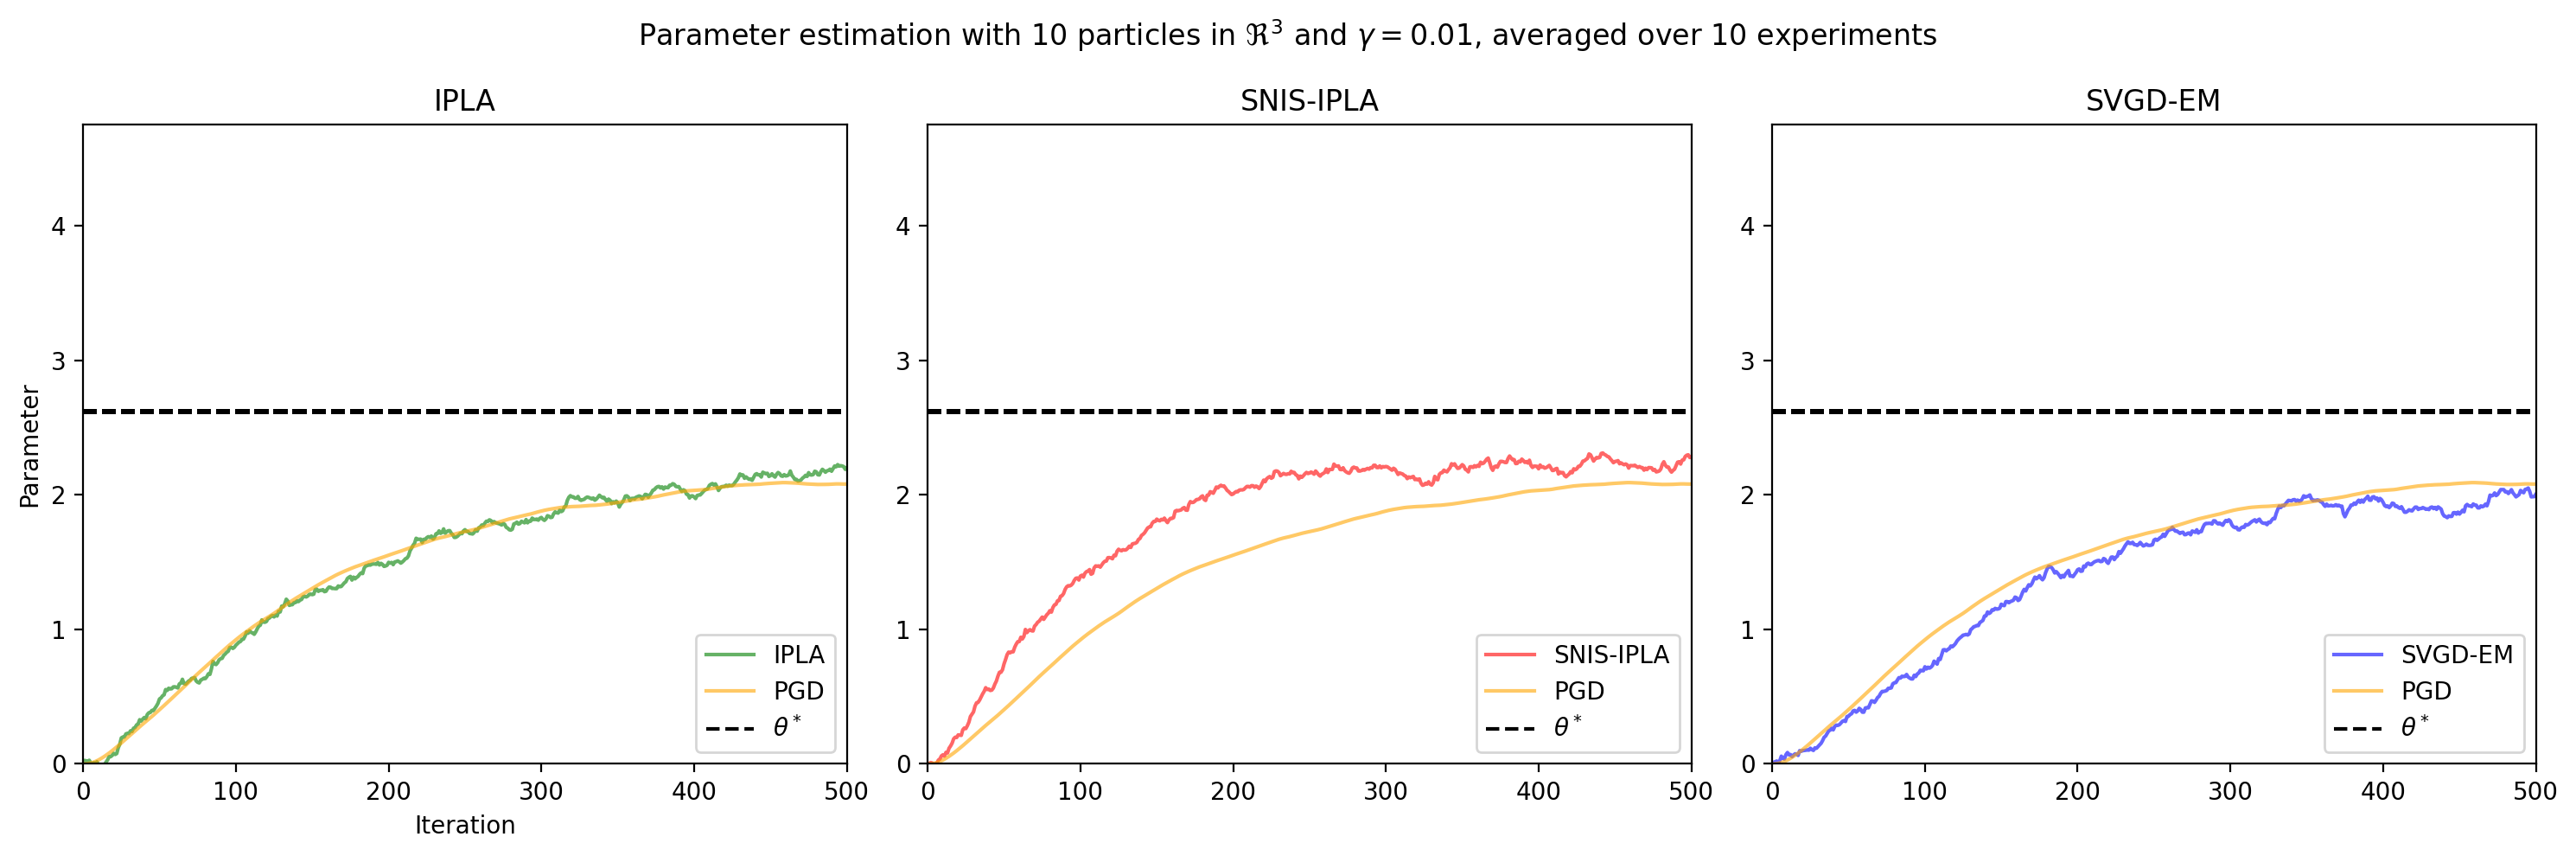

In [6]:
# Plot the results
# make two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))


ax1.plot(average_thetas_dict["IPLA"], color = "green", label="IPLA", alpha=0.6)
ax2.plot(average_thetas_dict["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
ax3.plot(average_thetas_dict["SVGD-EM"], color = "blue", label="SVGD-EM", alpha=0.6)
ax1.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax2.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax3.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax1.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax2.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax3.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Parameter')
ax1.set_xlim([0, nsteps])
ax1.set_ylim([0, 1.6*y.mean()])
ax1.set_title(f'IPLA')
ax1.legend(loc="lower right")
ax2.set_title(f'SNIS-IPLA')
ax2.legend(loc="lower right")
ax2.set_xlim([0, nsteps])
ax2.set_ylim([0, 1.6*y.mean()])
ax3.set_title(f'SVGD-EM')
ax3.legend(loc="lower right")
ax3.set_xlim([0, nsteps])
ax3.set_ylim([0, 1.6*y.mean()])

#ax1.set_yscale("log")
#ax2.set_yscale("log")
fig.suptitle(f"Parameter estimation with {Nparticles} particles in $\Re^{{{D}}}$ and $\gamma = {gamma_experiments}$, averaged over {nexperiments} experiments")
fig.tight_layout()
plt.show()

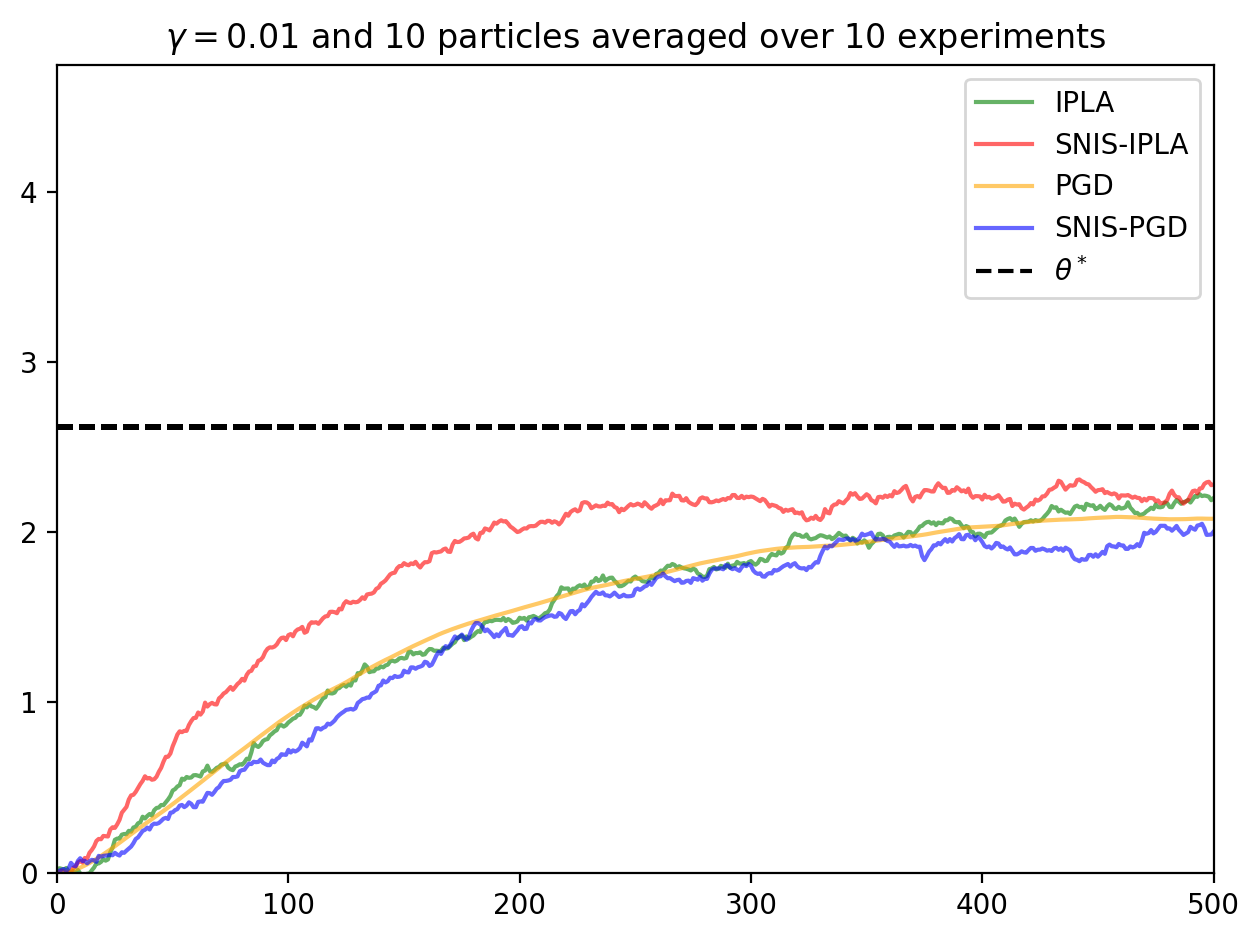

In [7]:
plt.plot(average_thetas_dict["IPLA"], color = "green", label="IPLA", alpha=0.6)
plt.plot(average_thetas_dict["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
plt.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
plt.plot(average_thetas_dict["SVGD-EM"], color = "blue", label="SVGD-EM", alpha=0.6)
plt.hlines(best_theta, 0, nsteps+1, linestyles="dashed", label = "$\\theta^*$", color="black")
plt.title(f"$\gamma = {gamma_experiments}$ and {Nparticles} particles averaged over {nexperiments} experiments")
plt.xlim([0, nsteps])
plt.ylim([0, 1.6*y.mean()])
plt.legend()
plt.tight_layout()
plt.show()

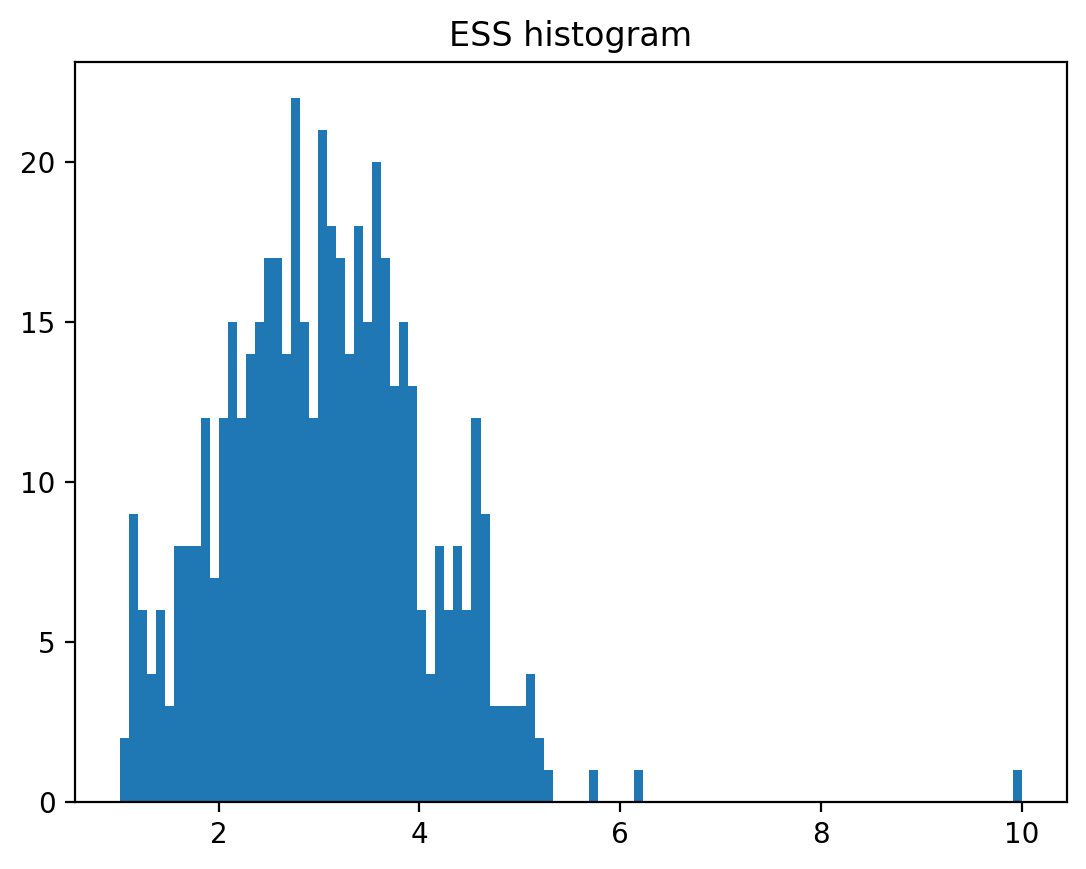

In [14]:
plt.hist(SNIS_IPLA_test.ESS_arr, bins=100)
plt.title("ESS histogram")

plt.show()

Our iterates are of the form:

\begin{align*}
\theta_{k+1} &= \theta_n - \gamma \sum_{i=1}^N W_i^k \nabla_{\theta}U(\theta_k, X_i^k) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}
Where:

$$
W_i^k = \frac{\exp(- U(\theta_k,X_i^k))}{\sum_{j=1}^{N} \exp(-U(\theta_k,X_j^k))}
$$

We can then rewrite the $\theta$ update as:
\begin{align*}
\theta_{k+1} &= \theta_n + \frac{\gamma}{\sum_{j=1}^{N} \exp(-U(\theta_k,X_j^k))} \sum_{i=1}^N \nabla_\theta\exp(- U(\theta_k,X_i^k)) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}

Recall that $U(\theta, X)=-\log p(\theta, X)$, so $p(\theta,\,X_i^k) = \exp(- U(\theta_k,X_i^k))$ and $\nabla_\theta\exp(- U(\theta_k,X_i^k)) = \nabla_\theta p(\theta,\,X_i^k)$. Hence:
\begin{align*}
\theta_{k+1} &= \theta_n + \frac{\gamma}{\sum_{j=1}^{N} p(\theta,\,X_j^k)} \sum_{i=1}^N \nabla_\theta p(\theta,\,X_i^k) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}

## Logistic Regression

In [149]:
D = 9
nsteps = 500
Nparticles = 15
X0 = np.zeros((D, Nparticles))
th0  = np.array([0.0])
nexperiments_regression = 1
grads_U_IPLA_regression = (ave_grad_U_theta_regression, grad_U_X_regression)
grads_U_SNIS_regression = (grad_U_theta_regression, grad_U_X_regression)
gamma_experiments_regression = 1e-2
average_thetas_dict_regression = {"PGD": np.zeros((nsteps+1,1)), "IPLA": np.zeros((nsteps+1,1)),"SNIS-IPLA": np.zeros((nsteps+1,1)), "SVGD-EM": np.zeros((nsteps+1,1))}
for experiment in tqdm(range(nexperiments_regression)):
    PGD_test_regression = PGD(th0, X0, grads_U_IPLA_regression, gamma=gamma_experiments_regression, y=y_train)
    IPLA_test_regression = IPLA(th0, X0, grads_U_IPLA_regression, gamma=gamma_experiments_regression, y=y_train)
    SNIS_IPLA_test_regression = SNIS_IPLA(th0, X0, U_regression, grads_U_SNIS_regression, gamma=gamma_experiments_regression, test=False, y=y_train)
    #SVGD_EM_test_regression = SVGD_EM(th0, X0, grads_U_IPLA_regression, exponential_kernel, grad_exponential_kernel_x1, gamma=gamma_experiments_regression, noise=1, y=y_train)
    for i in tqdm(range(nsteps)):
        PGD_test_regression.iterate()
        #print(np.shape(PGD_test_regression.X))
        IPLA_test_regression.iterate()
        SNIS_IPLA_test_regression.iterate()
        #SVGD_EM_test_regression.iterate()
        # print dimension of X 

    average_thetas_dict["PGD"] = average_thetas_dict["PGD"] + 1/nexperiments * np.array(PGD_test_regression.thetas)
    average_thetas_dict["IPLA"] = average_thetas_dict["IPLA"] + 1/nexperiments * np.array(IPLA_test_regression.thetas)
    average_thetas_dict["SNIS-IPLA"] = average_thetas_dict["SNIS-IPLA"] + 1/nexperiments * np.array(SNIS_IPLA_test_regression.thetas)
    average_thetas_dict["SVGD-EM"] = average_thetas_dict["SVGD-EM"] + 1/nexperiments * np.array(SVGD_EM_test_regression.thetas)


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/82/t8qzqs6x2f19402hdk543xd80000gn/T/ipykernel_78174/423465059.py:9: RuntimeWarning: overflow encountered in exp
  return  np.sum(-l*f + f*(np.exp(np.dot(f, Xi))/(1 + np.exp(np.dot(f, Xi)))).reshape(-1,1), axis=0) - (2/5)*(np.ones(Dx)*theta - Xi)
/var/folders/82/t8qzqs6x2f19402hdk543xd80000gn/T/ipykernel_78174/423465059.py:9: RuntimeWarning: invalid value encountered in divide
  return  np.sum(-l*f + f*(np.exp(np.dot(f, Xi))/(1 + np.exp(np.dot(f, Xi)))).reshape(-1,1), axis=0) - (2/5)*(np.ones(Dx)*theta - Xi)
/var/folders/82/t8qzqs6x2f19402hdk543xd80000gn/T/ipykernel_78174/423465059.py:24: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(np.dot(f, Xi))) - l*np.dot(f, Xi)) + (1/5)*np.dot(theta - Xi, theta - Xi)
100%|██████████| 500/500 [00:05<00:00, 92.89it/s]
/var/folders/82/t8qzqs6x2f19402hdk543xd80000gn/T/ipykernel_78174/346332582.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc